In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

sys.path.insert(0, "../")

%load_ext autoreload
%autoreload 2

In [2]:
import src

In [3]:
from src.models.hmr import get_hmr
from src.functional.hmr import hmr_inference
def get_hmr_pretrained(ckpt_path):
    ### load hmrnet
    hmrnet = get_hmr(pretrained=True)
    ckpt = torch.load(ckpt_path, map_location="cpu")
    hmrnet.load_state_dict(ckpt["hmrnet_state_dict"])
    hmrnet.eval();
    return hmrnet

In [4]:
from src.datasets.datasets_common import UNNORMALIZE
from src.functional.smpl import get_smpl_model
from src.utils.vis_utils import render_mesh_onto_image_batch
# from src.utils.vis_utils import make_square_grid

In [5]:
device = "cuda:0"
smpl_model = get_smpl_model("h36m").to(device)
smpl_model_faces = torch.tensor(smpl_model.faces.astype(int).copy()).unsqueeze(0)

# pick an experiment

In [6]:
ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/coco-all.pt"

# ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/output/train_hmr_fractional/train_hmr_frac__10/best.pth"
hmrnet = get_hmr_pretrained(ckpt)

hmrnet = hmrnet.to(device)


/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/hub.py:704: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


In [6]:
from src.utils.video_utils import write_video

In [7]:
def hmr_run(img, hmrnet, smpl_model, device, MAX_BATCH=32):
    j3d_arr = []
    for i, img_ in enumerate(torch.split(img, MAX_BATCH)):
        with torch.no_grad():
            smpl_rotmat, smpl_shape, camera = hmrnet(img_.to(device))
        out = smpl_model(
            betas=smpl_shape, 
            body_pose=smpl_rotmat[:, 1:], 
            global_orient=smpl_rotmat[:, :1],
            pose2rot=False,
        )
        j3d = out.joints
        j3d_arr.append(j3d.cpu())
    j3d_arr = torch.cat(j3d_arr, dim=0)
    return j3d_arr

## inference on 3DPW

In [37]:
from src.datasets.threedpw import ThreeDPW
videoOF_format = 1000
threedpw_ds = ThreeDPW(set="test", seqlen=300, debug=True, overlap=0., use_OFformat=False, videoOF_format=videoOF_format)


3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 97


# write videos of each seq


In [50]:
from src.datasets.threedpw import ThreeDPW
videoOF_format = 1000
threedpw_ds = ThreeDPW(set="test", seqlen=300, debug=True, overlap=0., use_OFformat=True, videoOF_format=videoOF_format)
fps = 30

for sample_idx in tqdm(range(97)):
    sample = threedpw_ds[sample_idx]
    img = UNNORMALIZE(sample['videoOF']).permute(0,2,3,1)
    video_path = f"./../paper_sub/fig__accelErr/rgb/fps_{fps}__{sample_idx:03d}.mp4"
    write_video((img.numpy()).astype(np.uint8), video_path, fps=fps)
    
    kp_path = f"./../paper_sub/fig__accelErr/gt/kp_3d__{sample_idx:03d}.pth"
    torch.save(sample['kp_3d'], kp_path)
#     break
    
    

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 97


  1%|█▍                                                                                                                                            | 1/97 [00:21<34:12, 21.38s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__000.mp4'


  2%|██▉                                                                                                                                           | 2/97 [00:46<37:45, 23.85s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__001.mp4'


  3%|████▍                                                                                                                                         | 3/97 [01:09<36:16, 23.15s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__002.mp4'


  4%|█████▊                                                                                                                                        | 4/97 [01:31<35:21, 22.81s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__003.mp4'


  5%|███████▎                                                                                                                                      | 5/97 [01:58<37:19, 24.35s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__004.mp4'


  6%|████████▊                                                                                                                                     | 6/97 [02:24<37:53, 24.99s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__005.mp4'


  7%|██████████▏                                                                                                                                   | 7/97 [02:51<38:03, 25.37s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__006.mp4'


  8%|███████████▋                                                                                                                                  | 8/97 [03:16<37:39, 25.39s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__007.mp4'


  9%|█████████████▏                                                                                                                                | 9/97 [03:42<37:41, 25.70s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__008.mp4'


 10%|██████████████▌                                                                                                                              | 10/97 [04:10<38:11, 26.34s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__009.mp4'


 11%|███████████████▉                                                                                                                             | 11/97 [04:32<35:59, 25.11s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__010.mp4'


 12%|█████████████████▍                                                                                                                           | 12/97 [05:00<36:45, 25.94s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__011.mp4'


 13%|██████████████████▉                                                                                                                          | 13/97 [05:26<36:26, 26.03s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__012.mp4'


 14%|████████████████████▎                                                                                                                        | 14/97 [05:51<35:17, 25.51s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__013.mp4'


 15%|█████████████████████▊                                                                                                                       | 15/97 [06:12<32:54, 24.08s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__014.mp4'


 16%|███████████████████████▎                                                                                                                     | 16/97 [06:35<32:07, 23.79s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__015.mp4'


 18%|████████████████████████▋                                                                                                                    | 17/97 [07:02<33:13, 24.92s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__016.mp4'


 19%|██████████████████████████▏                                                                                                                  | 18/97 [07:28<33:03, 25.11s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__017.mp4'


 20%|███████████████████████████▌                                                                                                                 | 19/97 [07:54<33:07, 25.48s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__018.mp4'


 21%|█████████████████████████████                                                                                                                | 20/97 [08:17<31:35, 24.61s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__019.mp4'


 22%|██████████████████████████████▌                                                                                                              | 21/97 [08:39<30:26, 24.03s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__020.mp4'


 23%|███████████████████████████████▉                                                                                                             | 22/97 [09:03<29:42, 23.76s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__021.mp4'


 24%|█████████████████████████████████▍                                                                                                           | 23/97 [09:28<29:50, 24.19s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__022.mp4'


 25%|██████████████████████████████████▉                                                                                                          | 24/97 [09:53<29:42, 24.42s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__023.mp4'


 26%|████████████████████████████████████▎                                                                                                        | 25/97 [10:15<28:26, 23.70s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__024.mp4'


 27%|█████████████████████████████████████▊                                                                                                       | 26/97 [10:38<27:58, 23.65s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__025.mp4'


 28%|███████████████████████████████████████▏                                                                                                     | 27/97 [11:05<28:38, 24.55s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__026.mp4'


 29%|████████████████████████████████████████▋                                                                                                    | 28/97 [11:30<28:24, 24.70s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__027.mp4'


 30%|██████████████████████████████████████████▏                                                                                                  | 29/97 [11:56<28:21, 25.02s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__028.mp4'


 31%|███████████████████████████████████████████▌                                                                                                 | 30/97 [12:23<28:33, 25.57s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__029.mp4'


 32%|█████████████████████████████████████████████                                                                                                | 31/97 [12:49<28:15, 25.69s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__030.mp4'


 33%|██████████████████████████████████████████████▌                                                                                              | 32/97 [13:15<28:08, 25.98s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__031.mp4'


 34%|███████████████████████████████████████████████▉                                                                                             | 33/97 [13:37<26:32, 24.88s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__032.mp4'


 35%|█████████████████████████████████████████████████▍                                                                                           | 34/97 [14:07<27:43, 26.41s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__033.mp4'


 36%|██████████████████████████████████████████████████▉                                                                                          | 35/97 [14:34<27:17, 26.41s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__034.mp4'


 37%|████████████████████████████████████████████████████▎                                                                                        | 36/97 [14:57<25:45, 25.34s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__035.mp4'


 38%|█████████████████████████████████████████████████████▊                                                                                       | 37/97 [15:19<24:23, 24.39s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__036.mp4'


 39%|███████████████████████████████████████████████████████▏                                                                                     | 38/97 [15:44<24:05, 24.49s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__037.mp4'


 40%|████████████████████████████████████████████████████████▋                                                                                    | 39/97 [16:05<22:53, 23.67s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__038.mp4'


 41%|██████████████████████████████████████████████████████████▏                                                                                  | 40/97 [16:33<23:39, 24.90s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__039.mp4'


 42%|███████████████████████████████████████████████████████████▌                                                                                 | 41/97 [17:00<23:52, 25.57s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__040.mp4'


 43%|█████████████████████████████████████████████████████████████                                                                                | 42/97 [17:27<23:51, 26.03s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__041.mp4'


 44%|██████████████████████████████████████████████████████████████▌                                                                              | 43/97 [17:53<23:15, 25.83s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__042.mp4'


 45%|███████████████████████████████████████████████████████████████▉                                                                             | 44/97 [18:18<22:44, 25.75s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__043.mp4'


 46%|█████████████████████████████████████████████████████████████████▍                                                                           | 45/97 [18:40<21:17, 24.57s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__044.mp4'


 47%|██████████████████████████████████████████████████████████████████▊                                                                          | 46/97 [19:04<20:44, 24.40s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__045.mp4'


 48%|████████████████████████████████████████████████████████████████████▎                                                                        | 47/97 [19:32<21:09, 25.38s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__046.mp4'


 49%|█████████████████████████████████████████████████████████████████████▊                                                                       | 48/97 [19:54<20:03, 24.57s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__047.mp4'


 51%|███████████████████████████████████████████████████████████████████████▏                                                                     | 49/97 [20:24<20:49, 26.03s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__048.mp4'


 52%|████████████████████████████████████████████████████████████████████████▋                                                                    | 50/97 [20:52<20:52, 26.65s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__049.mp4'


 53%|██████████████████████████████████████████████████████████████████████████▏                                                                  | 51/97 [21:18<20:19, 26.52s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__050.mp4'


 54%|███████████████████████████████████████████████████████████████████████████▌                                                                 | 52/97 [21:46<20:11, 26.92s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__051.mp4'


 55%|█████████████████████████████████████████████████████████████████████████████                                                                | 53/97 [22:09<18:53, 25.77s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__052.mp4'


 56%|██████████████████████████████████████████████████████████████████████████████▍                                                              | 54/97 [22:33<17:56, 25.04s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__053.mp4'


 57%|███████████████████████████████████████████████████████████████████████████████▉                                                             | 55/97 [22:55<16:55, 24.17s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__054.mp4'


 58%|█████████████████████████████████████████████████████████████████████████████████▍                                                           | 56/97 [23:17<16:06, 23.57s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__055.mp4'


 59%|██████████████████████████████████████████████████████████████████████████████████▊                                                          | 57/97 [23:45<16:41, 25.05s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__056.mp4'


 60%|████████████████████████████████████████████████████████████████████████████████████▎                                                        | 58/97 [24:17<17:32, 26.98s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__057.mp4'


 61%|█████████████████████████████████████████████████████████████████████████████████████▊                                                       | 59/97 [24:47<17:44, 28.02s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__058.mp4'


 62%|███████████████████████████████████████████████████████████████████████████████████████▏                                                     | 60/97 [25:14<17:07, 27.78s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__059.mp4'


 63%|████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 61/97 [25:42<16:38, 27.74s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__060.mp4'


 64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 62/97 [26:08<15:51, 27.18s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__061.mp4'


 65%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 63/97 [26:35<15:21, 27.11s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__062.mp4'


 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 64/97 [26:58<14:17, 25.99s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__063.mp4'


 67%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 65/97 [27:21<13:20, 25.00s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__064.mp4'


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 66/97 [27:45<12:42, 24.60s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__065.mp4'


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 67/97 [28:09<12:11, 24.38s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__066.mp4'


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 68/97 [28:34<11:55, 24.66s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__067.mp4'


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 69/97 [28:58<11:26, 24.52s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__068.mp4'


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 70/97 [29:26<11:29, 25.53s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__069.mp4'


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 71/97 [29:50<10:51, 25.07s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__070.mp4'


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 72/97 [30:17<10:39, 25.56s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__071.mp4'


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 73/97 [30:42<10:12, 25.54s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__072.mp4'


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 74/97 [31:10<10:00, 26.11s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__073.mp4'


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 75/97 [31:32<09:10, 25.04s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__074.mp4'


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 76/97 [31:54<08:28, 24.21s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__075.mp4'


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 77/97 [32:20<08:11, 24.56s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__076.mp4'


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 78/97 [32:49<08:10, 25.84s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__077.mp4'


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 79/97 [33:17<07:56, 26.47s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__078.mp4'


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 80/97 [33:45<07:40, 27.08s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__079.mp4'


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 81/97 [34:12<07:10, 26.91s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__080.mp4'


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 82/97 [34:42<06:59, 27.97s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__081.mp4'


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 83/97 [35:08<06:23, 27.42s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__082.mp4'


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 84/97 [35:33<05:47, 26.72s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__083.mp4'


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 85/97 [36:00<05:19, 26.59s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__084.mp4'


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 86/97 [36:25<04:49, 26.29s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__085.mp4'


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 87/97 [36:52<04:26, 26.61s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__086.mp4'


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 88/97 [37:20<04:01, 26.88s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__087.mp4'


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 89/97 [37:47<03:34, 26.78s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__088.mp4'


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 90/97 [38:12<03:04, 26.39s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__089.mp4'


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 91/97 [38:41<02:42, 27.03s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__090.mp4'


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 92/97 [39:08<02:16, 27.24s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__091.mp4'


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 93/97 [39:35<01:48, 27.07s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__092.mp4'


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 94/97 [39:57<01:16, 25.56s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__093.mp4'


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 95/97 [40:21<00:50, 25.16s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__094.mp4'


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 96/97 [40:47<00:25, 25.21s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__095.mp4'


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [41:14<00:00, 25.51s/it]

Video is saved to './../paper_sub/fig__accelErr/rgb/fps_30__096.mp4'


# save j3d of exp-s

In [55]:
# exp_name = "hmr_orig"
# ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/coco-all.pt"

exp_name = "model1"
ckpt = "../output/ft_w_coco_seqlen2_2try/ft_w_coco__3dpw_test__data_1_ofc_0_1_seqlen2/best.pth"

exp_name = "model2"
ckpt = "../output/ft_w_coco_seqlen2_normOFloss/ft_w_coco__3dpw_test__data_1_ofc_0_001_seqlen2_normOFloss/best.pth"

exp_name = "model3"
ckpt = "../output/ft_w_coco_seqlen2_normOFloss/ft_w_coco__3dpw_test__data_1_ofc_0_01_seqlen2_normOFloss/best.pth"   

exp_name = "model4"
ckpt = "../output/ft_w_coco_seqlen2_normOFloss_OFonHR/ft_w_coco__3dpw_test__data_1_ofc_0_01_seqlen2_normOFloss_OFonHR/best.pth"


hmrnet = get_hmr_pretrained(ckpt)
hmrnet = hmrnet.to(device)


In [63]:
from src.datasets.threedpw import ThreeDPW
threedpw_ds = ThreeDPW(set="test", seqlen=300, debug=True, overlap=0., use_OFformat=False)
fps = 30

for exp_name, ckpt in [
        ["model1", "../output/ft_w_coco_seqlen2_2try/ft_w_coco__3dpw_test__data_1_ofc_0_1_seqlen2/best.pth"],
        ["model2", "../output/ft_w_coco_seqlen2_normOFloss/ft_w_coco__3dpw_test__data_1_ofc_0_001_seqlen2_normOFloss/best.pth"],
        ["model3", "../output/ft_w_coco_seqlen2_normOFloss/ft_w_coco__3dpw_test__data_1_ofc_0_01_seqlen2_normOFloss/best.pth"],
        ["model4", "../output/ft_w_coco_seqlen2_normOFloss_OFonHR/ft_w_coco__3dpw_test__data_1_ofc_0_01_seqlen2_normOFloss_OFonHR/best.pth"],   
    ]:
    print(exp_name)
    hmrnet = get_hmr_pretrained(ckpt)
    hmrnet = hmrnet.to(device)
    for sample_idx in tqdm(range(97)):
        sample = threedpw_ds[sample_idx]
        img = sample['video']
        j3d = hmr_run(img, hmrnet, smpl_model, device)


        kp_path = f"./../paper_sub/fig__accelErr/{exp_name}/kp_3d__{sample_idx:03d}.pth"
        torch.save(j3d, kp_path)
    

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 97
model1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [12:22<00:00,  7.66s/it]


model2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [12:07<00:00,  7.50s/it]


model3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [15:28<00:00,  9.57s/it]


model4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [15:09<00:00,  9.37s/it]


In [6]:
from src.losses.pose_eval import PAMPJPE
from src.losses.pose_eval import AccelerationError

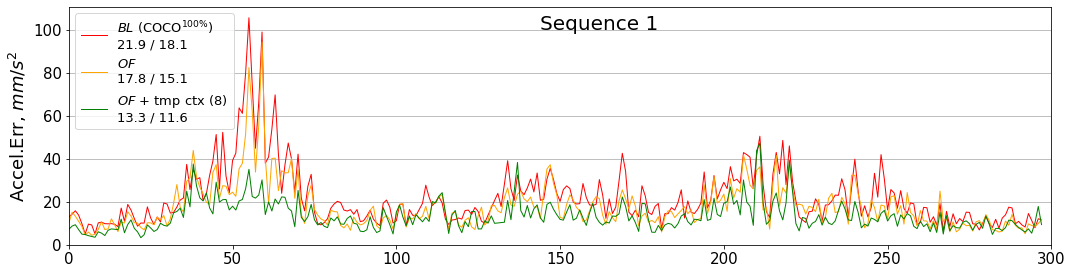

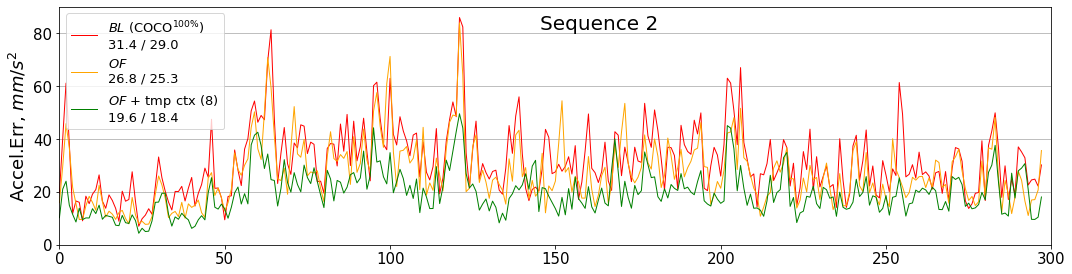

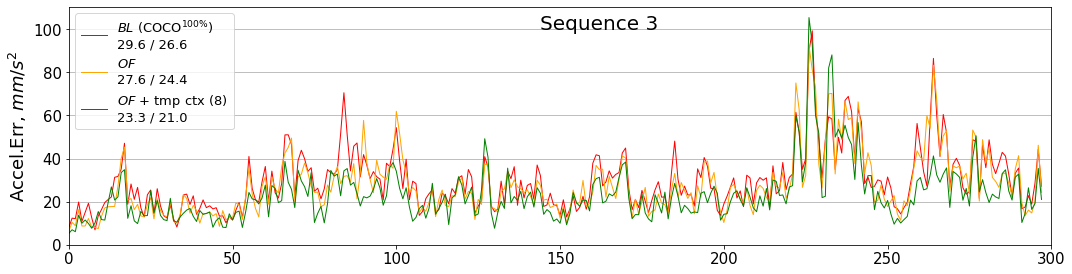

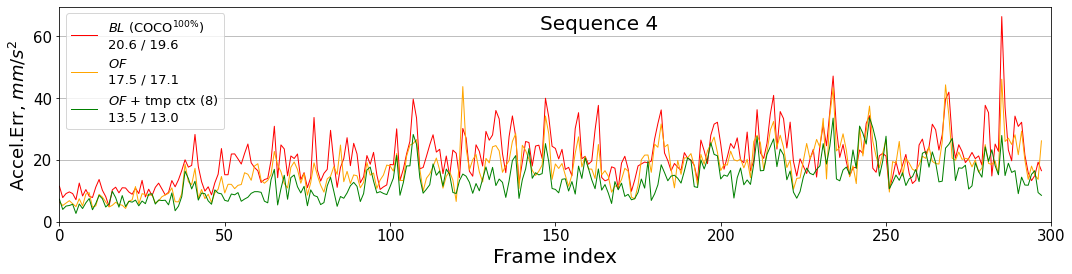

In [10]:
### 4 separate plots

# for sample_idx in [2,7,8,11,17,20,24,26,46,51,56,58, 59,68,69,76,96]:
# for sample_idx in [2,7,8,11,17,20,24,26,46,51,56,58, 59,68,69,76]:
# for sample_idx in [46,56,96]:
for sample_idx_num, sample_idx in enumerate([2, 46, 56, 59]):
    pa_mpjpe = PAMPJPE()
    accel_err = AccelerationError()

    common_path = "./../paper_sub/fig__accelErr"
    kp3d_gt = torch.load(f"{common_path}/gt/kp_3d__{sample_idx:03d}.pth")

    fig, ax = plt.subplots(1,1,figsize=(15,4))
    max_accel_err = 0 ### for ticks
    for exp_name, exp_name_plot, color in [
        ["hmr_orig", r"$BL$ (COCO$^{100\%}$)", 'r'],
        ['model2', r"$OF$", 'orange'],
        ['model1', r"$OF$ + tmp ctx (8)", 'green'],
        ]:
        kp3d_pred = torch.load(f"{common_path}/{exp_name}/kp_3d__{sample_idx:03d}.pth")
        pa_loss = pa_mpjpe(kp3d_pred, kp3d_gt) * 1000.
        accel_err_loss = accel_err(kp3d_pred, kp3d_gt) * 1000.
        if accel_err_loss.max() > max_accel_err: max_accel_err = accel_err_loss.max()
            
        ax.plot(
            accel_err_loss, 
            linewidth=1,
            color=color,
            label=f"{exp_name_plot} \n{accel_err_loss.mean():.1f} / {accel_err_loss.median():.1f}")
    ax.legend(fontsize=13, loc='upper left')
    ax.annotate(f"Sequence {sample_idx_num+1}", (0.5,0.85), xycoords='figure fraction', fontsize=20)
    yticks = int(max_accel_err // 20 * 20)
    yticks = list(range(0, yticks+1, 20))
    
    ax.grid(axis='y')
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0, right=300)
    ax.set_yticks(yticks)
    ax.tick_params(axis='x', which='major', labelsize=15)
    ax.tick_params(axis='y', which='major', labelsize=15)
    if sample_idx_num + 1 == 4:
        ax.set_xlabel("Frame index", fontsize=20);
    ax.set_ylabel(r"Accel.Err, $mm/s^2$", fontsize=18);
    fig.tight_layout()
    fig.savefig(
#         f"./../paper_sub/fig__accelErr/to_plot/sequence{sample_idx_num+1}.pdf", 
        f"./../new_figs/sequence{sample_idx_num+1}.pdf", 
        format="pdf", bbox_inches="tight")
    
    

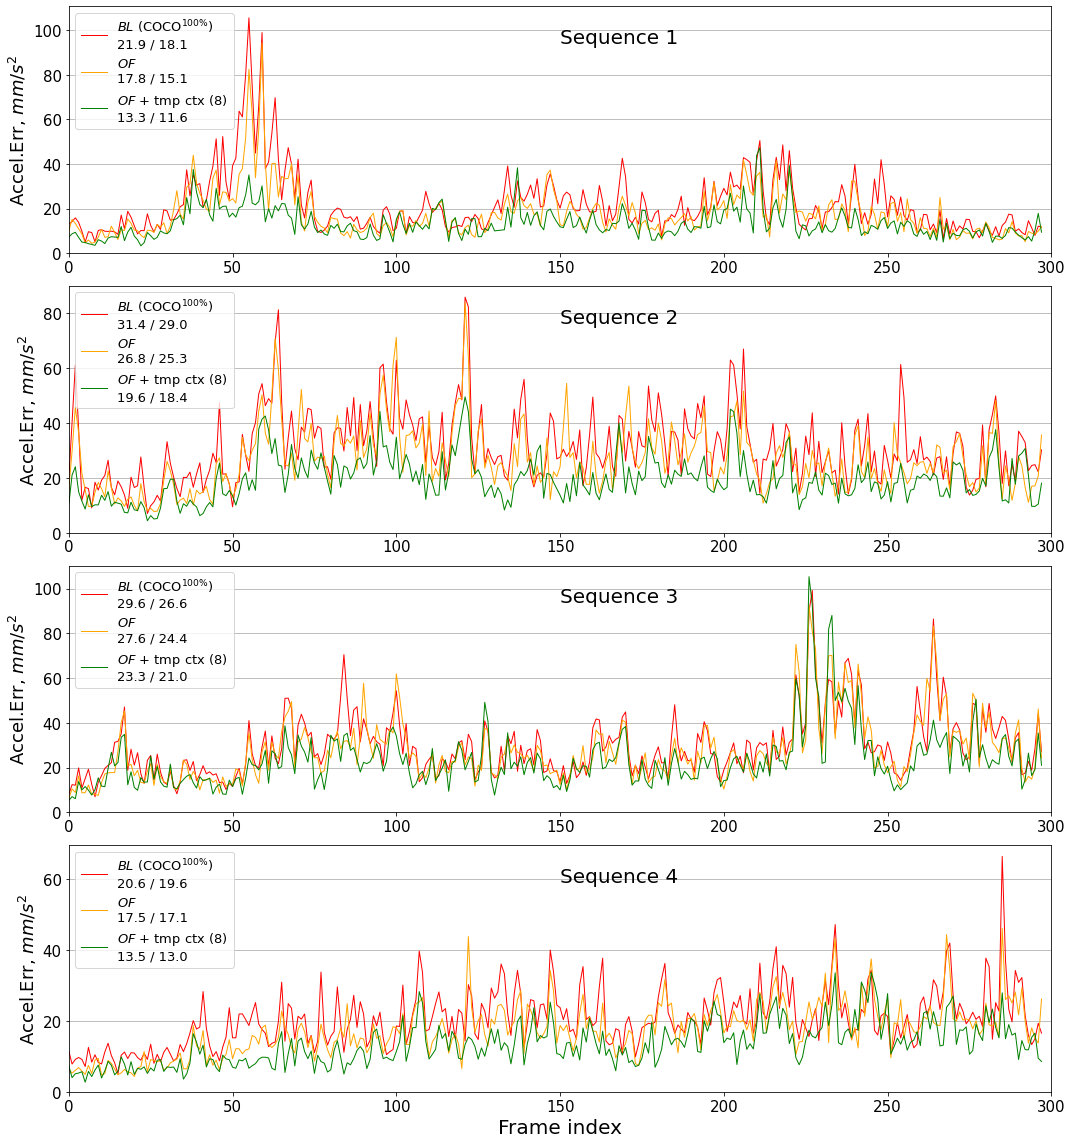

In [11]:
### 1 shared plot

fig, ax = plt.subplots(4,1,figsize=(15,16))
for sample_idx_num, sample_idx in enumerate([2, 46, 56, 59]):
    pa_mpjpe = PAMPJPE()
    accel_err = AccelerationError()

    common_path = "./../paper_sub/fig__accelErr"
    kp3d_gt = torch.load(f"{common_path}/gt/kp_3d__{sample_idx:03d}.pth")

    max_accel_err = 0 ### for ticks
    for exp_name, exp_name_plot, color in [
        ["hmr_orig", r"$BL$ (COCO$^{100\%}$)", 'r'],
        ['model2', r"$OF$", 'orange'],
        ['model1', r"$OF$ + tmp ctx (8)", 'green'],
        ]:
        kp3d_pred = torch.load(f"{common_path}/{exp_name}/kp_3d__{sample_idx:03d}.pth")
        pa_loss = pa_mpjpe(kp3d_pred, kp3d_gt) * 1000.
        accel_err_loss = accel_err(kp3d_pred, kp3d_gt) * 1000.
        if accel_err_loss.max() > max_accel_err: max_accel_err = accel_err_loss.max()
            
        ax[sample_idx_num].plot(
            accel_err_loss, 
            linewidth=1,
            color=color,
            label=f"{exp_name_plot} \n{accel_err_loss.mean():.1f} / {accel_err_loss.median():.1f}")
    ax[sample_idx_num].legend(fontsize=13, loc='upper left')
    ax[sample_idx_num].annotate(f"Sequence {sample_idx_num+1}", (0.5,0.85), xycoords='axes fraction', fontsize=20)
    yticks = int(max_accel_err // 20 * 20)
    yticks = list(range(0, yticks+1, 20))
    
    ax[sample_idx_num].grid(axis='y')
    ax[sample_idx_num].set_ylim(bottom=0)
    ax[sample_idx_num].set_xlim(left=0, right=300)
    ax[sample_idx_num].set_yticks(yticks)
    ax[sample_idx_num].tick_params(axis='x', which='major', labelsize=15)
    ax[sample_idx_num].tick_params(axis='y', which='major', labelsize=15)
    if sample_idx_num + 1 == 4:
        ax[sample_idx_num].set_xlabel("Frame index", fontsize=20);
    ax[sample_idx_num].set_ylabel(r"Accel.Err, $mm/s^2$", fontsize=18);
fig.tight_layout()
fig.savefig(
#     f"./../paper_sub/fig__accelErr/to_plot/sequences_all.pdf", 
    f"./../new_figs/sequences_all.pdf",
    format="pdf", bbox_inches="tight")
    
    

# chose 46, 56, 96. 

## 46, 56 - fine, 96 - bad! chose 2, 59 instead

In [18]:
def hmr_run_verts(img, hmrnet, smpl_model, device, MAX_BATCH=32):
    verts_arr = []
    for i, img_ in enumerate(torch.split(img, MAX_BATCH)):
        with torch.no_grad():
            smpl_rotmat, smpl_shape, camera = hmrnet(img_.to(device))
        out = smpl_model(
            betas=smpl_shape, 
            body_pose=smpl_rotmat[:, 1:], 
            global_orient=smpl_rotmat[:, :1],
            pose2rot=False,
        )
        verts3d = out.vertices
        verts_arr.append(verts3d.cpu())
        
    verts_arr = torch.cat(verts_arr, dim=0)
    return verts_arr

In [19]:
from src.datasets.threedpw import ThreeDPW
threedpw_ds = ThreeDPW(set="test", seqlen=300, debug=True, overlap=0., use_OFformat=False)
imgs = {}
# for idx in [46,56,96]:
for idx in [2,59]:
    sample = threedpw_ds[idx]
    img = sample['video']
    imgs[idx] = img



3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 97


In [20]:
def render0back(img, verts, faces, device, MAX_BATCH=32):
    renders_arr = []
    for img_, verts_ in zip(
        torch.split(img, MAX_BATCH), 
        torch.split(verts, MAX_BATCH)):
        
        renders = render_mesh_onto_image_batch(
            img_, 
            verts_.to(device), 
            faces.repeat(len(verts_),1,1).to(device), 
            device=device
        )
        renders_arr.append(renders)
    return torch.cat(renders_arr, dim=0)

In [21]:
for exp_name, ckpt in [
        ["hmr_orig", "/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/coco-all.pt"],
        ["model2", "../output/ft_w_coco_seqlen2_normOFloss/ft_w_coco__3dpw_test__data_1_ofc_0_001_seqlen2_normOFloss/best.pth"],
        ["model1", "../output/ft_w_coco_seqlen2_2try/ft_w_coco__3dpw_test__data_1_ofc_0_1_seqlen2/best.pth"],
    ]:
    print(exp_name)
    hmrnet = get_hmr_pretrained(ckpt)
    hmrnet = hmrnet.to(device)
  
    for sample_idx in [2,59]:
#     for sample_idx in [46,56,96]:
        img = imgs[sample_idx]
        verts = hmr_run_verts(img, hmrnet, smpl_model, device)
        
        verts_path = f"./../paper_sub/fig__accelErr/chosen_seqs2/verts__{exp_name}__{sample_idx:03d}.pth"
        torch.save(verts, verts_path)
    

hmr_orig


/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/hub.py:704: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


model2
model1


In [25]:
# from src.utils.video_utils import get_frames

# imgs_full = {}
# for sample_idx in [46,56,96]:
#     common_path = "./../paper_sub/fig__accelErr"
#     img, fps = get_frames(f"{common_path}/rgb/fps_30__{sample_idx:03d}.mp4")
#     img = torch.tensor(img)
#     imgs_full[sample_idx] = img


videoOF_format = 1000
from src.datasets.threedpw import ThreeDPW
threedpw_ds = ThreeDPW(set="test", seqlen=300, debug=True, overlap=0., use_OFformat=True, videoOF_format=videoOF_format)

imgs_full = {}
# for sample_idx in [2, 59]:
for sample_idx in [46,56]:
    sample = threedpw_ds[sample_idx]
    img = UNNORMALIZE(sample['videoOF']).permute(0,2,3,1)
    imgs_full[sample_idx] = img
    
    

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 97


In [26]:
common_path = "./../paper_sub/fig__accelErr"
img_size = 1000
fps = 30
# for sample_idx in [2,7,8,11,17,20,24,26,46,51,59,68,69,76,96]:
# for sample_idx in [2, 59]:
for sample_idx in [46,56]:
    print(sample_idx)
    
    final = imgs_full[sample_idx].clone() / 255

    for exp_name in [
        "hmr_orig", 
        'model2', 
        'model1', 
        ]:
        
        verts = torch.load(f"{common_path}/chosen_seqs2/verts__{exp_name}__{sample_idx:03d}.pth")
        verts *= img_size * 0.45
        verts[...,:2] += img_size / 2

        rendered_imgs = render0back(
            torch.zeros(len(verts),3,img_size,img_size), 
            verts, smpl_model_faces, device=device)
        
        d = 100
        final = torch.cat((final, rendered_imgs[:,:,d:-d]), dim=-2)
        print(final.shape)
        
    final = (final.numpy() * 255).astype(np.uint8)
    print(final.shape)
    
    video_path = f"./../paper_sub/fig__accelErr/final/fps_{fps}__{sample_idx:03d}.mp4"
    write_video(final, video_path, fps=fps)

46
torch.Size([300, 1000, 1800, 3])
torch.Size([300, 1000, 2600, 3])
torch.Size([300, 1000, 3400, 3])
(300, 1000, 3400, 3)
Video is saved to './../paper_sub/fig__accelErr/final/fps_30__046.mp4'
56
torch.Size([300, 1000, 1800, 3])
torch.Size([300, 1000, 2600, 3])
torch.Size([300, 1000, 3400, 3])
(300, 1000, 3400, 3)
Video is saved to './../paper_sub/fig__accelErr/final/fps_30__056.mp4'
